# Mandelbrot and Julia Set

## Imports

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
from IPython.display import clear_output
import multiprocessing as mp
from fastcore.parallel import parallel
from time import sleep
from datetime import datetime
import random
from fastprogress import progress_bar
from pathlib2 import Path

## Methods

In [2]:
def create_blank(width, height, rgb_color=(0, 0, 0)):
    '''
    Returns a blank image of indicated color.
    '''
    img = np.zeros((height, width, 3), np.uint8)
    c = tuple(reversed(rgb_color)) # reverse RGB clors (opencv uses bgr colors)
    img[:] = c
    return img

In [3]:
def f(z, c):
    '''
    Calculates the next generation of the quadratic set of the Mandelbrot or Julia set.
    '''
    return (z[0] * z[0] - z[1] * z[1] + c[0], 2 * z[0] * z[1] + c[1])

In [4]:
def f_n_mbs(c, n = 1000, use_tresh = True, tresh = 2):
    '''
    ============================
    TODO: replace for by while
    ============================
    
    Test a complex numner as a member of the Mandelbrot set by n iterations.
    The number of iterations is returned together with the norm of the final number z after n iteration.
    For use_tresh=True iterating is stopped as soon as the norm of the resulting number is larger than
    the treshold tresh.
    '''
    z = (0, 0)
    if (use_tresh):
        for i in range(0, n):
            z = f(z, c)
            z2 = z[0] * z[0] + z[1] + z[1]
            if (z2 > tresh * tresh):
                return (i + 1) / n, z2
    else:
        for i in range(0, n):
            z = f(z, c)
    z2 = z[0] * z[0] + z[1] + z[1]
    return (i + 1) / n, np.sqrt(z2)

In [5]:
def f_n_js(z, c = (0, 0), n = 1000, use_tresh = True, tresh = 2):
    '''
    ============================
    TODO: replace for by while
    ============================
    
    Test a complex numner as a member of the Julia set by n iterations.
    The number of iterations is returned together with the norm of the final number z after n iteration.
    For use_tresh=True iterating is stopped as soon as the norm of the resulting number is larger than
    the treshold tresh.
    '''
    if (use_tresh):
        for i in range(0, n):
            z = f(z, c)
            z2 = z[0] * z[0] + z[1] + z[1]
            if (z2 > tresh * tresh - tresh):
                return (i + 1) / n, z2
    else:
        for i in range(0, n):
            z = f(z, c)
    z2 = max(0, z[0] * z[0] + z[1] + z[1])
    return (i + 1) / n, np.sqrt(z2)

In [6]:
def get_julia_set(res = (1024, 640), dim = (-1.6, 1.6, -1.0, 1.0), c = (-.8, .156), n_it = 1000, tresh = 3):
    '''
    Calculates the Julia set as defined ny its paramters.
    
    Parameters
    ----------
    res : immage resolutdion in pixels as a tuple res = (x_res, y_res)
    dim : the dimension/area of the complex plane to be considered within the calculations
          dim = (zx_min, zx_max, zy_min, zy_max)
    c :   a constant complex number defined as a tuple with real and imaginary part
    '''
    zx_min = dim[0]
    zx_max = dim[1]
    zy_min = dim[2]
    zy_max = dim[3]
    
    x_res = res[0]
    y_res = res[1]
    
    dzx = (zx_max - zx_min) / x_res
    dzy = (zy_max - zy_min) / y_res
    
    #img = create_blank(x_res, y_res)
    #img = np.zeros((y_res, x_res), np.uint8)
    img = np.zeros((y_res, x_res))

    for x in range(x_res):
        
        zx = zx_min + x * dzx
        
        for y in range(y_res):

            zy = zy_min + y * dzy
            
            n, f_n = f_n_js((zx, zy), c = c, n = n_it, tresh=tresh)
            #img[y][x] = (n, n, n)
            img[y_res - 1 - y][x] = n
                
    return img

## Julia Set

### Calculate with preview and increasing resolution

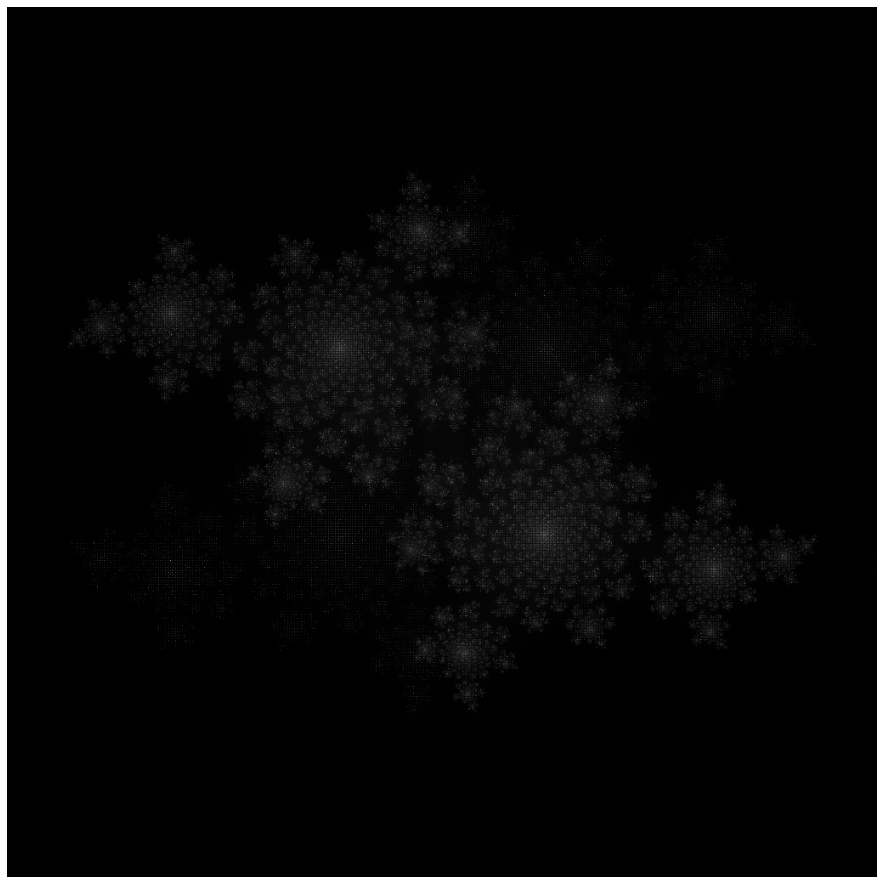

CPU times: user 34 s, sys: 347 ms, total: 34.3 s
Wall time: 32.5 s


In [7]:
%%time

fs = (16, 16)
dim = 1024
img = create_blank(dim, dim, (255, 255, 255))
calc = np.zeros((dim, dim))

reMin = -1.6
reMax = 1.6
imMin = -1.6
imMax = 1.6
dRe = (reMax - reMin) / dim
dIm = (imMax - imMin) / dim



c = (-0.4, 0.6)

step = dim
while (step >= 1):
    for y in range(0, dim, step):
        for x in range(0, dim, step):
            
            if (calc[y][x] == 1):
                color = img[y][x]
            else:
                # calc the current pixel
                re = reMin + x * dRe
                im = imMin + y * dIm
                it, zn = f_n_js((re, im), c, n = 1000, tresh=3)
                b = it * 255
                g = b
                r = b
                color = (g, b, r)
                #r = max(255, zn / 100000)
                #g = 255 * it / 1000
                #b = max(255, r * g)
                #color = (b, g, r)
                img[dim - 1 - y][x] = color
                calc[y][x] = 1
            
            # fill the empty pixels
            for xi in range(x, x + step):
                for yi in range(y, y + step):
                    img[dim - 1 - yi][xi] = color
    
    step = step // 2
    
    # update image
    clear_output(wait=True)
    plt.figure(figsize=fs)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show();

### Calculate in background directly with full resolution

In [8]:
%%time

img_js = get_julia_set()
#img_js = get_julia_set()

CPU times: user 16.6 s, sys: 95.6 ms, total: 16.7 s
Wall time: 16.8 s


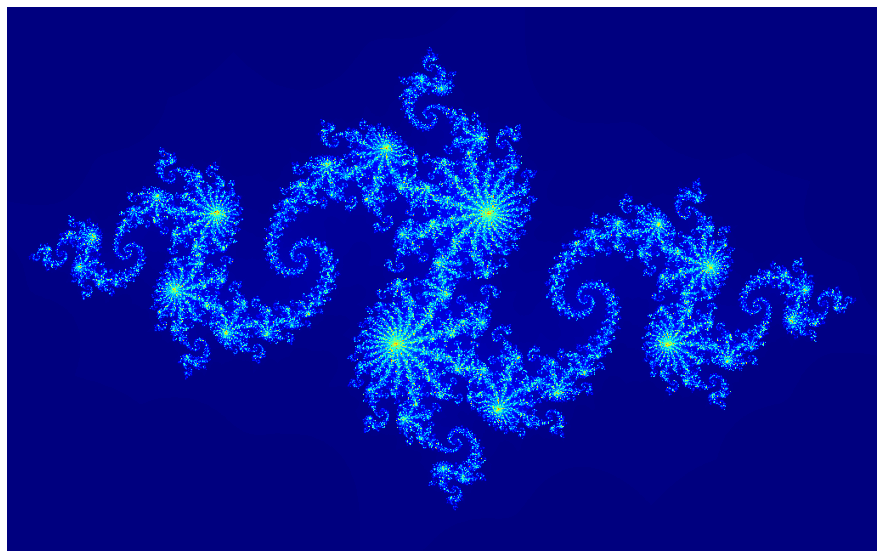

In [9]:
fig = plt.figure(figsize=(16,10))
plt.imshow(img_js, cmap = 'jet', vmin=0, vmax = 1)
plt.axis('off')
#fig.savefig('bla.jpg', dpi = 300, bbox_inches='tight')
plt.show()
plt.close(fig)

### Calculate for diefferemt c-values and store the images

In [10]:
def do_calc_and_write_julia_set(c):
    fn = Path(f'Julia/julia_{c[0]:.3f}_{c[1]:.3f}i.jpg')
    if fn.exists():
        #print(f'File {fn} exists already --> skipping')
        return
    img_js = get_julia_set(res = (256, 256), dim = (-1.6, 1.6, -1.6, 1.6), c = c)
    img = (255 - (img_js * 255))
    img = img.astype(np.uint8)
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    cv2.imwrite(fn.as_posix(), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [18]:
%%time

res = (256, 256)
dim = (-1.6, 1.6, -1.6, 1.6)

cx_min = dim[0]
cx_max = dim[1]
cy_min = dim[2]
cy_max = dim[3]

n = 500
dcx = (cx_max - cx_min) / n
dcy = (cy_max - cy_min) / n

c_values = list()
for i in range(0, n):
    cx = cx_min + i * dcx
    for j in range(0, n):
        cy = cy_min + j * dcy
        c_values.append((cx, cy))

_ = parallel(do_calc_and_write_julia_set, c_values, n_workers=4)

## OpenCV and ColorMap

In [10]:
img_js.shape

(640, 1024)

In [12]:
img_js

array([[0.002, 0.002, 0.002, ..., 0.001, 0.001, 0.001],
       [0.002, 0.002, 0.002, ..., 0.001, 0.001, 0.001],
       [0.002, 0.002, 0.002, ..., 0.001, 0.001, 0.001],
       ...,
       [0.001, 0.001, 0.001, ..., 0.002, 0.002, 0.002],
       [0.001, 0.001, 0.001, ..., 0.002, 0.002, 0.002],
       [0.001, 0.001, 0.001, ..., 0.002, 0.002, 0.002]])

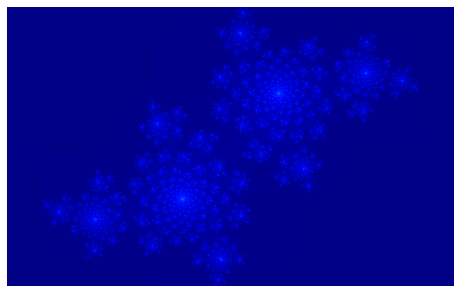

In [30]:
img = (255 - (img_js * 255))
img = img.astype(np.uint8)

img = cv2.applyColorMap(img, cv2.COLORMAP_JET)

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(img)
plt.show();

In [34]:
target_dir = 'test'
cx, cy = -.32, -.64

img_js = get_julia_set(res, dim, (cx, cy))
        
img = (255 - (img_js * 255))
img = img.astype(np.uint8)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
fn = f'{target_dir}/julia_{cx:.3f}_{cy:.3f}i.png'
cv2.imwrite(fn, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

True

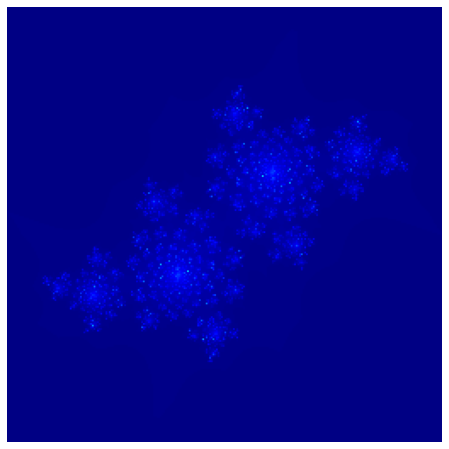

In [32]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(img)
plt.show();